<img src=docs/tudelft_logo.jpg width=50%>

## Data-driven Design and Analyses of Structures and Materials (3dasm)

## Lecture 5

### Miguel A. Bessa | <a href = "mailto: M.A.Bessa@tudelft.nl">M.A.Bessa@tudelft.nl</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* [Car figure](https://korkortonline.se/en/theory/reaction-braking-stopping/)

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the 3dasm conda environment (see Lecture 1).

2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
conda activate 3dasm
jupyter notebook
```
4. Open notebook of this Lecture.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.style.use("seaborn") # style for plotting that comes from seaborn
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Bayesian inference for one hidden rv
    - Prior
    - Likelihood
    - Marginal likelihood
    - Posterior
    - Gaussian pdf's product

**Reading material**: This notebook + Chapter 3

### Recall the "slightly more complicated" car stopping distance problem (with two rv's)

We defined the governing model with two rv's $z_1$ and $z_2$ as:

$\require{color}{\color{red}y} = {\color{blue}z_1}\cdot x + {\color{magenta}z_2}\cdot x^2$

- ${\color{red}y}$ is the **output**: the car stopping distance (in meters)
- ${\color{blue}z_1}$ is an <a title="random variable">rv</a> representing the driver's reaction time (in seconds)
- ${\color{magenta}z_2}$ is another <a title="random variable">rv</a> that depends on the coefficient of friction, the inclination of the road, the weather, etc. (in m$^{-1}$s$^{-2}$).
- $x$ is the **input**: constant car velocity (in m/s).

where we knew the "true" distributions of the rv's: $z_1 \sim \mathcal{N}(\mu_{z_1}=1.5,\sigma_{z_1}^2=0.5^2)$, and $z_2 \sim \mathcal{N}(\mu_{z_2}=0.1,\sigma_{z_2}^2=0.01^2)$.

In [2]:
# This cell is hidden during presentation. It's just to define a function to plot the governing model of
# the car stopping distance problem. Defining a function that creates a plot allows to repeatedly run
# this function on cells used in this notebook.
def car_fig_2rvs(ax):
    x = np.linspace(3, 83, 1000)
    mu_z1 = 1.5; sigma_z1 = 0.5;  # parameters of the "true" p(z_1)
    mu_z2 = 0.1; sigma_z2 = 0.01; # parameters of the "true" p(z_2)
    mu_y = mu_z1*x + mu_z2*x**2 # From Homework of Lecture 4
    sigma_y = np.sqrt( (x*sigma_z1)**2 + (x**2*sigma_z2)**2 ) # From Homework of Lecture 4
    ax.set_xlabel("x (m/s)", fontsize=20) # create x-axis label with font size 20
    ax.set_ylabel("y (m)", fontsize=20) # create y-axis label with font size 20
    ax.set_title("Car stopping distance problem with two rv's", fontsize=20); # create title with font size 20
    ax.plot(x, mu_y, 'k:', label="Governing model $\mu_y$")
    ax.fill_between(x, mu_y - 1.9600 * sigma_y,
                    mu_y + 1.9600 * sigma_y,
                    color='k', alpha=0.2,
                    label='95% confidence interval ($\mu_y \pm 1.96\sigma_y$)') # plot 95% credence interval
    ax.legend(fontsize=15)

In [3]:
# This cell is also hidden during presentation.
from scipy.stats import norm # import the normal dist, as we learned before!
def samples_y_with_2rvs(N_samples,x): # observations/measurements/samples for car stop. dist. prob. with 2 rv's
    mu_z1 = 1.5; sigma_z1 = 0.5;
    mu_z2 = 0.1; sigma_z2 = 0.01;
    samples_z1 = norm.rvs(mu_z1, sigma_z1, size=N_samples) # randomly draw samples from the normal dist.
    samples_z2 = norm.rvs(mu_z2, sigma_z2, size=N_samples) # randomly draw samples from the normal dist.
    samples_y = samples_z1*x + samples_z2*x**2 # compute the stopping distance for samples of z_1 and z_2
    return samples_y # return samples of y

Empirical mean[y] is 608.0187342208175 (real mean[y]=675)
Empirical std[y] is 73.21708134271651 (real std[y]=67.6)


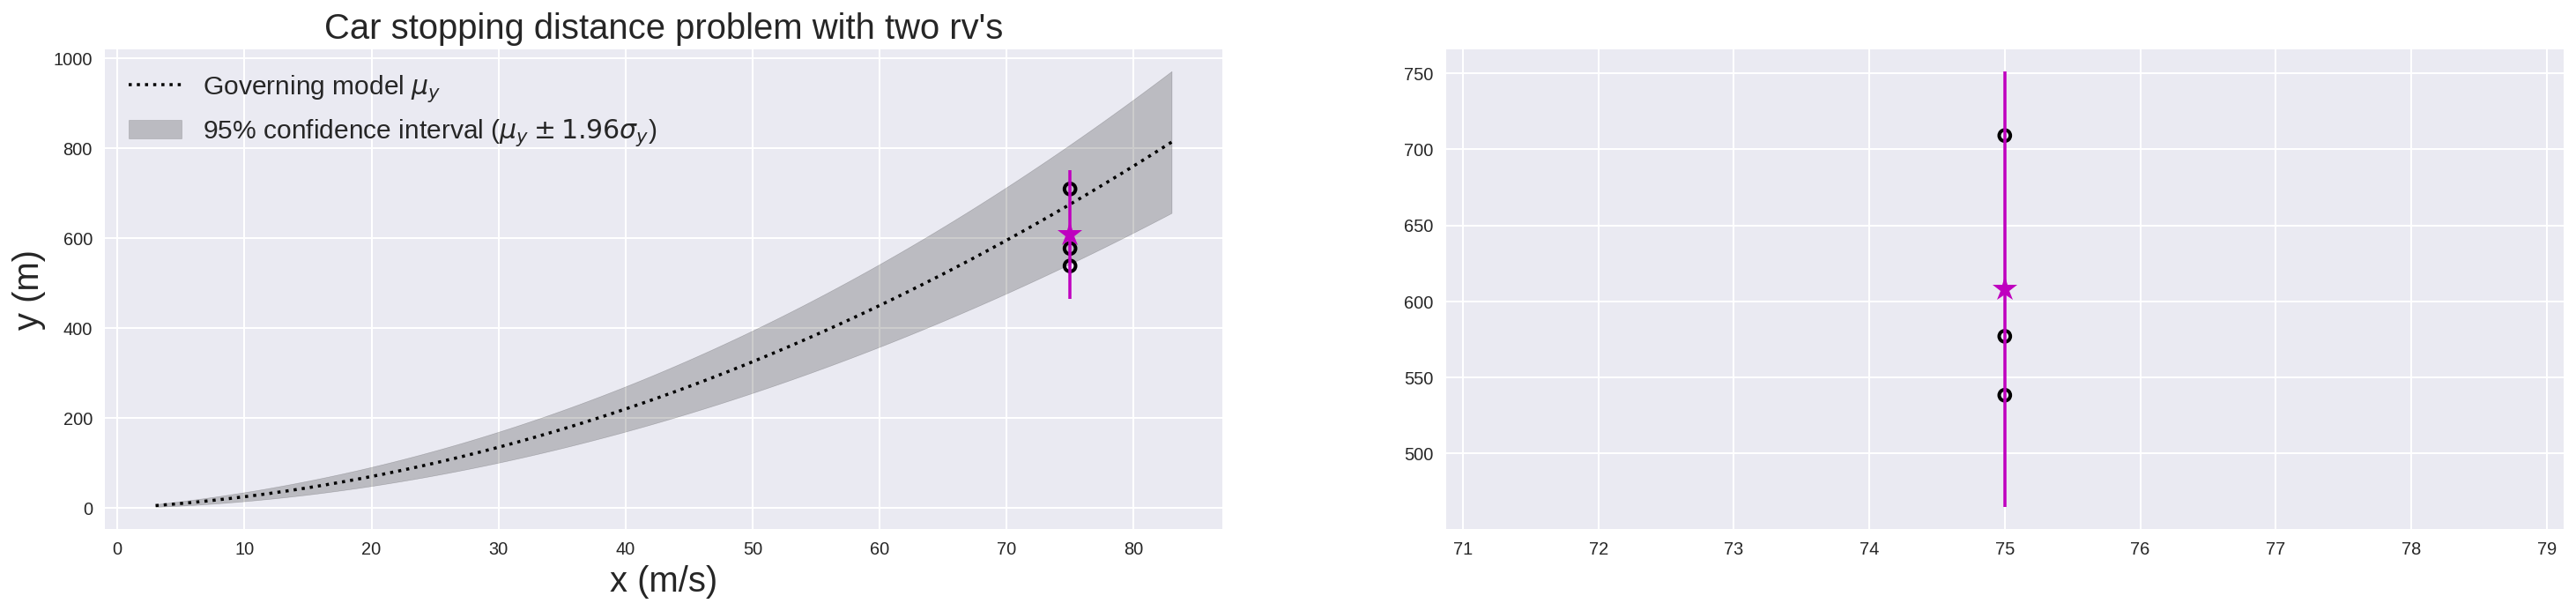

In [4]:
# vvvvvvvvvvv this is just a trick so that we can run this cell multiple times vvvvvvvvvvv
fig_car_new, ax_car_new = plt.subplots(1,2); plt.close() # create figure and close it
if fig_car_new.get_axes():
    del ax_car_new; del fig_car_new # delete figure and axes if they exist
    fig_car_new, ax_car_new = plt.subplots(1,2) # create them again
# ^^^^^^^^^^^ end of the trick ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
N_samples = 3 # CHANGE THIS NUMBER AND RE-RUN THE CELL
x = 75; empirical_y = samples_y_with_2rvs(N_samples, x); # Empirical measurements of N_samples at x=75
empirical_mu_y = np.mean(empirical_y); empirical_sigma_y = np.std(empirical_y); # empirical mean and std
car_fig_2rvs(ax_car_new[0]) # a function I created to include the background plot of the governing model
for i in range(2): # create two plots (one is zooming in on the error bar)
    ax_car_new[i].errorbar(x , empirical_mu_y,yerr=1.96*empirical_sigma_y, fmt='m*', markersize=15);
    ax_car_new[i].scatter(x*np.ones_like(empirical_y),empirical_y, s=40,
                          facecolors='none', edgecolors='k', linewidths=2.0)
print("Empirical mean[y] is",empirical_mu_y, "(real mean[y]=675)")
print("Empirical std[y] is",empirical_sigma_y,"(real std[y]=67.6)")
fig_car_new.set_size_inches(25, 5) # scale figure to be wider (since there are 2 subplots)

### Note: comparison of car stopping distance problem of Lecture 3  & Lecture 4

* The car stopping distance problem in Lecture 3 only had one rv.
* While this car stopping distance problem (introduced in Lecture 4) **has 2 rv's**.
    - Observing the governing model when knowing the "true" distributions of $z_1$ and $z_2$ we see that:
        * The expected value (mean) of $y$ is the same for both problems because $\mu_{z_2}=0.1$.
        * The variance of $y$ is higher for this problem because of the additional randomness introduced by $z_2$.
            - For example, for $x=75$ m/s the $\text{std}[y] \approx 67.6$ m while it was 37.5 when only $z_1$ was an rv.

### Car stopping distance problem with 2 rv's but only 1 rv being unknown

<img src="docs/reaction-braking-stopping.svg" title="Car stopping distance" width="25%" align="right">

Today we will finally do some predictions!

Recall the Homework of Lecture 4, and consider the car stopping distance problem for constant velocity $x=75$ m/s and for which **it is known** that $z_2 \sim \mathcal{N}(z_2|\mu_{z_2}=0.1,\sigma_{z_2}^2=0.01^2)$.

The only information that we do not know is the driver's reaction time $z$ (here we call it $z$, instead of $z_1$ as in Lecture 4, because this is the only hidden variable so we can **simplify the notation**).

* Can we predict $p(y)$ without knowing $p(z)$?

Yes!! If we use Bayes' rule!

### Recall the Homework of Lecture 4

<img src="docs/reaction-braking-stopping.svg" title="Car stopping distance" width="25%" align="right">

From last lecture's Homework, you demonstrated that the conditional pdf of the stopping distance given the reaction time $z$ (for convenience we write here $z$ instead of $z_1$) is

$$
p(y|z) = \mathcal{N}\left(y | \mu_{y|z}=w z+b, \sigma_{y|z}^2=s^2\right)
$$

where $w$, $b$ and $s$ are all constants that you determined to be:

$w=x=75$

$b=x^2\mu_{z_2}=75^2\cdot0.1=562.5$

$s^2=(x^2 \sigma_{z_2})^2=(75^2\cdot0.01)^2=56.25^2$

because we are considering that the car is going at constant velocity $x=75$ m/s and that we know $z_2= \mathcal{N}(z_2|\mu_{z_2}=0.1,\sigma_{z_2}^2=0.01^2)$.

### Solution to Homework of Lecture 4

<img src="docs/reaction-braking-stopping.svg" title="Car stopping distance" width="25%" align="right">

What we know:

$\require{color}{\color{red}y} = {\color{blue}z_1}\cdot 75 + {\color{magenta}z_2}\cdot 75^2 = 75 {\color{blue}z_1} + 5625 {\color{magenta}z_2}$

where $z_1 \sim \mathcal{N}(\mu_{z_1}=1.5,\sigma_{z_1}^2=0.5^2)$, and $z_2 \sim \mathcal{N}(\mu_{z_2}=0.1,\sigma_{z_2}^2=0.01^2)$.

1. To calculate the conditional pdf $p(y|z_1)$, i.e. the observation distribution, we note that:

$$
y \equiv f(z_1) = x z_1 + x^2 z_2 \Rightarrow z_2 = \frac{y}{x^2}-\frac{z_1}{x} \equiv g(y)
$$

From the change of variables formula (Lecture 3),

$$\begin{align}
p_y(y) &= p_z\left( g(y) \right) \left| \frac{d}{dy}g(y)\right| \\
&=  \mathcal{N}\left( \frac{y}{x^2}-\frac{z_1}{x}\left| \mu_{z_2}, \sigma_{z_2}^2\right.\right) \left|\frac{1}{x^2}\right| \\
&= \frac{1}{\sqrt{2\pi \sigma_{z_2}^2}} \exp\left[ -\frac{1}{2\sigma_{z_2}^2}\left( \frac{y}{x^2}-\frac{z_1}{x}-\mu_{z_2} \right)^2 \right] \left|\frac{1}{x^2}\right|\\
&= \frac{1}{\sqrt{2\pi \left(x^2\sigma_{z_2}\right)^2}} \exp\left[ -\frac{1}{2\left(x^2\sigma_{z_2}\right)^2}\left( y-x z_1-x^2\mu_{z_2} \right)^2 \right] 
\end{align}
$$

So, the conditional pdf $p(y|z_1)$ is also a Gaussian:

$$
p(y|z_1) = \mathcal{N}\left( y| \mu_{y|z_1}=x^2\mu_{z_2}+x z_1, \sigma_{y|z_1}=\left( x^2 \sigma_{z_2}\right)^2 \right)
$$

2. The joint distribution is simply:

$$
p(y, z_1) = p(y|z_1)p(z_1) = \mathcal{N}\left( y| \mu_{y|z_1}=x^2\mu_{z_2}+x z_1, \sigma_{y|z_1}=\left( x^2 \sigma_{z_2}\right)^2 \right) \mathcal{N}\left( z_1| \mu_{z_1}=1.5, \sigma_{z_1}=0.5^2 \right)
$$

which we will learn how to calculate in this lecture (spoiler alert: it's another gaussian 😆)

3. The covariance matrix is calculated as:

$
\mathbb{E}[z_1] = \mu_{z_1} \, , \quad \mathbb{V}[z_1] = \sigma_{z_1}^2
$

$
\mathbb{E}[y] = \mathbb{E}[z_1 x + x^2 z_2]=\mathbb{E}[z_1]x + x^2 \mathbb{E}[z_2] = x\mu_{z_1}+x^2\mu_{z_2}
$

$\begin{align}
\mathbb{E}[y^2] &= \mathbb{E}\left[ (z_1 x + x^2 z_2)(z_1 x + x^2 z_2) \right]\\
&= \mathbb{E}\left[ z_1^2 x^2+2x^3z_1 z_2 + x^4 z_2^2 \right] \\
&= x^2 \mathbb{E}[z_1^2] + 2x^3 \mathbb{E}[z_1 z_2] + x^4 \mathbb{E}[z_2^2] \\
&= x^2\left( \sigma_{z_1}^2 + \mu_{z_1}^2\right) + 2x^3 \mu_{z_1}\mu_{z_2} + x^4\left( \sigma_{z_2}^2 + \mu_{z_2}^2\right)
\end{align}
$

$\begin{align}
\mathbb{V}[y] &= \mathbb{E}[y^2]-\mathbb{E}[y]^2\\
&= x^2\left( \sigma_{z_1}^2 + \mu_{z_1}^2\right) + 2x^3 \mu_{z_1}\mu_{z_2} + x^4\left( \sigma_{z_2}^2 + \mu_{z_2}^2\right) - \left( x\mu_{z_1}+x^2\mu_{z_2}\right)^2 \\
&= \left( x\sigma_{z_1}\right)^2+\left(x^2\sigma_{z_2}\right)^2 \\
\end{align}
$

$\begin{align}
\text{Cov}[y, z_1] &= \mathbb{E}[y z_1] - \mathbb{E}[y] \mathbb{E}[z_1] \\
&= \mathbb{E}[z_1^2 x + x^2 z_2 z_1] - \left(x\mu_{z_1}+x^2\mu_{z_2}\right) \mu_{z_1} \\
&= x\mathbb{E}[z_1^2]+x^2\mathbb{E}[z_1 z_2]  - \left(x\mu_{z_1}+x^2\mu_{z_2}\right) \mu_{z_1} \\
&= x\left( \sigma_{z_1}^2 + \mu_{z_1}^2\right)+x^2\mu_{z_1}\mu_{z_2}  - x\mu_{z_1}-x^2x\mu_{z_1}\mu_{z_2} \\
&= x\sigma_{z_1}^2
\end{align}
$

From where we can finally calculate the Covariance matrix:

$$
\begin{align}
\boldsymbol{\Sigma} &= \text{Cov}\begin{bmatrix}y\\ z_1\end{bmatrix}
 = \begin{bmatrix}
\mathbb{V}[y] & \text{Cov}[y,z_1] \\
\text{Cov}[z_1,y] & \mathbb{V}[z_1]
\end{bmatrix}\\
&= \begin{bmatrix}
\left( x\sigma_{z_1}\right)^2+\left(x^2\sigma_{z_2}\right)^2 & x\sigma_{z_1}^2 \\
x\sigma_{z_1}^2 & \sigma_{z_1}^2
\end{bmatrix}
\end{align}
$$

### Understanding the Bayes' rule

$\require{color}$
$$
{\color{green}p(z|y)} = \frac{ {\color{blue}p(y|z)}{\color{red}p(z)} } {p(y)}
$$

* ${\color{red}p(z)}$ is the **prior distribution**
* ${\color{blue}p(y|z)}$ is the **observation distribution** (conditional pdf)
* $p(y)$ is the **marginal distribution**
* ${\color{green}p(z|y)}$ is the **posterior distribution**

### A note about the term "distribution"

The term distribution can mean two things:
1. For **continuous** <a title="random variables">rv's</a>, the term *distribution* means *probability density function* (<a title="probability density function">pdf</a>).

2. For **discrete** <a title="random variables">rv's</a> the term *distribution* means *probability mass function* (<a title="probability mass function">pmf</a>), as we will see later in the course.

We won't talk about categorical distributions or <a title="probability mass functions">pmf's</a> for a while. So, for now, when you see the term *distribution* it is the same as saying <a title="probability density function">pdf</a>.

### Understanding the Bayes' rule

Let's start by understanding the usefulness of Bayes' rule by calculating the posterior $p(z|y)$ for the car stopping distance problem (Homework of Lecture 4).

As we mentioned, for our problem we know the **observation distribution**:

$p(y|z) = \mathcal{N}\left(y | \mu_{y|z}=w z+b, \sigma_{y|z}^2\right)$

where $\sigma_{y|z} = \text{const}$, as well as $w$ and $b$. 

but we **don't know** the prior $p(z)$.

### Prior: our beliefs about the problem

If we have absolutely no clue about what the distribution of the hidden rv $z$ is, then we can use a **Uniform distribution** (a.k.a. uninformative prior).

This distribution assigns equal probability to any value of $z$ within an interval $z \in (z_{min}, z_{max})$.

$$
p(z) = \frac{1}{C_z}
$$

where $C_z = z_{max}-z_{min}$ is the **normalization constant** of the Uniform pdf, i.e. the value that guarantees that $p(z)$ integrates to one.

For the time being, we will not assume any particular values for $z_{max}$ and $z_{min}$. So, we will consider the completely uninformative prior: $z_{max}\rightarrow \infty$ and $z_{min}\rightarrow -\infty$. If we had some information, we could consider some values for these bounds (e.g. $z_{min} = 0$ seconds would be the limit of the fastest reaction time that is humanly possible, and $z_{max} = 3$ seconds would be the slowest reaction time of a human being).

### Summary of our Model

1. The **observation distribution**:

$$\begin{align}
p(y|z) &= \mathcal{N}\left(y | \mu_{y|z}=w z+b, \sigma_{y|z}^2\right) \\
&= \frac{1}{C_{y|z}} \exp\left[ -\frac{1}{2\sigma_{y|z}^2}(y-\mu_{y|z})^2\right]
\end{align}
$$

where $C_{y|z} = \sqrt{2\pi \sigma_{y|z}^2}$ is the **normalization constant** of the Gaussian pdf, and where $\mu_{y|z}=w z+b$, with $w$, $b$ and $\sigma_{y|z}^2$ being constants, as previously mentioned.

2. and the **prior distribution**: $p(z) = \frac{1}{C_z}$

where $C_z = z_{max}-z_{min}$ is the **normalization constant** of the Uniform pdf, i.e. the value that guarantees that $p(z)$ integrates to one.

### Posterior from Bayes' rule

Since we have defined the **observation distribution** and the **prior distribution**, we can now compute the posterior distribution from Bayes' rule.

But this requires a bit of algebra... Let's do it!

First, in order to apply Bayes' rule $p(z|y) = \frac{ p(y|z)p(z)}{p(y)}$ we need to calculate $p(y)$.

$p(y)$ is obtained by marginalizing the joint distribution wrt $z$:

$
p(y) = \int p(y|z)p(z) dz
$

which implies an integration over $z$. So, let's rewrite $p(y|z)$ so that the integration becomes easier.

$$\begin{align}
p(y|z) &= \mathcal{N}\left(y | \mu_{y|z}=w z+b, \sigma_{y|z}^2\right) \\
&= \frac{1}{C_{y|z}} \exp\left[ -\frac{1}{2\sigma_{y|z}^2}(y-(w z+b))^2\right] \\
&= \frac{1}{C_{y|z}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\} \\
&= \frac{1}{|w|}\frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\}
\end{align}
$$


Note: This Gaussian pdf $\mathcal{N}\left(z | \frac{y-b}{w}, \left(\frac{\sigma_{y|z}}{w}\right)^2\right)$ is unnormalized when written wrt $z$ (due to $\frac{1}{|w|}$).

We can now calculate the marginal distribution $p(y)$:

$$
\begin{align}
p(y) &= \int p(y|z)p(z) dz \\
&= \int \frac{1}{|w|}\frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\} \frac{1}{C_z} dz
\end{align}
$$

We can rewrite this expression as,

$$\require{color}
\begin{align}
p(y) &= \frac{1}{|w|\cdot C_z} {\color{blue}\int \frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\} dz} \\
\end{align}
$$

What is the result for the <font color='blue'>blue term</font>?

From where we conclude that the marginal distribution is:

$$\require{color}
p(y) = \frac{1}{|w| C_z }
$$

So, now we can determine the posterior:

$$\require{color}
\begin{align}
p(z|y) &= \frac{ p(y|z)p(z)}{p(y)} \\
&= |w| C_z \cdot \frac{1}{|w|}\frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\} \cdot \frac{1}{C_z}\\
&= \frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}}\exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\}
\end{align}
$$

which is a **normalized** Gaussian pdf in $z$: $\mathcal{N}\left(z | \frac{y-b}{w}, \left(\frac{\sigma_{y|z}}{w}\right)^2\right)$

* **This is what the Bayes' rule does!** Computes the posterior $p(z|y)$ from $p(y|z)$ and $p(z)$.

## Why should we care about the Bayes' rule?

There are a few reasons:

1. As we will see, models are usually (always?) wrong.


2. But our beliefs may be a bit closer to reality! Bayes' rule enables us to get better models if our beliefs are reasonable!


3. We don't observe distributions. We observe **DATA**. Bayes' rule is a very powerful way to predict the distribution of our quantity of interest (here: $y$) from data!

## Bayes' rule applied to observed data

Previously, we already introduced Bayes' rule when applied to observed data $\mathcal{D}_y$.

$\require{color}$
$$
{\color{green}p(z|y=\mathcal{D}_y)} = \frac{ {\color{blue}p(y=\mathcal{D}_y|z)}{\color{red}p(z)} } {p(y=\mathcal{D}_y)} = \frac{ {\color{magenta}p(y=\mathcal{D}_y, z)} } {p(y=\mathcal{D}_y)}
$$

* ${\color{red}p(z)}$ is the **prior** distribution
* ${\color{blue}p(y=\mathcal{D}_y|z)}$ is the **likelihood** function
* ${\color{magenta}p(y=\mathcal{D}_y, z)}$ is the **joint likelihood** (product of likelihood function with prior distribution)
* $p(y=\mathcal{D}_y)$ is the **marginal likelihood**
* ${\color{green}p(z|y=\mathcal{D}_y)}$ is the **posterior**

We can write Bayes' rule as <font color='green'>posterior</font> $\propto$ <font color='blue'>likelihood</font> $\times$ <font color='red'>prior </font>, where we are ignoring the denominator $p(y=\mathcal{D}_y)$ because it is just a **constant** independent of the hidden variable $z$.

## Bayes' rule applied to observed data

But remember that Bayes' rule is just a way to calculate the posterior:

$$
p(z|y=\mathcal{D}_y) = \frac{ p(y=\mathcal{D}_y|z)p(z) } {p(y=\mathcal{D}_y)}
$$

Usually, what we really want is to be able to predict the distribution of the quantity of interest (here: $y$) after observing some data $\mathcal{D}_y$:

$$\require{color}
{\color{orange}p(y|y=\mathcal{D}_y)} = \int p(y|z) p(z|y=\mathcal{D}_y) dz
$$

which is often written in simpler notation: $p(y|\mathcal{D}_y) = \int p(y|z) p(z|\mathcal{D}_y) dz$

### Bayesian inference for car stopping distance problem

Now we will solve the first Bayesian ML problem from some given data $y=\mathcal{D}_y$:

| $y_i$ (m) |
| ---- |
| 601.5 |
| 705.9 |
| 693.8 |
| ...   |
| 711.3 |

where the data $\mathcal{D}_y$ could be a Pandas dataframe with $N$ data points ($N$ rows).

* **Very Important Question (VIQ)**: Can we calculate the **likelihood** function from this data?

### Likelihood for car stopping distance problem

Of course! As we saw a few cells ago, the **likelihood** is obtained by evaluating the **observation distribution** at the data $\mathcal{D}_y$.

Noting that each observation in $\mathcal{D}_y$ is independent of each other, then:

$$
p(y=\mathcal{D}_y | z) = \prod_{i=1}^{N} p(y=y_i|z) = p(y=y_1|z)p(y=y_2|z) \cdots p(y=y_N|z)
$$

which gives the **probability density** of observing that data if using our observation distribution (part of our model!).

#### Calculating the likelihood

Let's calculate it:

$$
\begin{align}
p(y=\mathcal{D}_y | z) &= \prod_{i=1}^{N} p(y=y_i|z) \\
&= \prod_{i=1}^{N} \frac{1}{C_{y|z}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y_i-b}{w}\right)\right]^2\right\}
\end{align}
$$

This seems a bit daunting... I know. Do not dispair yet!

##### Product of Gaussian pdf's of the same rv $z$

It can be shown that the product of $N$ univariate Gaussian pdf's of the same rv $z$ is:

$$
\prod_{i=1}^{N} \mathcal{N}(z|\mu_i, \sigma_i^2) = C \cdot \mathcal{N}(z|\mu, \sigma^2)
$$

with mean: $\mu = \sigma^2 \left( \sum_{i=1}^{N} \frac{\mu_i}{\sigma_i^2}\right)$

variance: $\sigma^2= \frac{1}{\sum_{i=1}^{N} \frac{1}{\sigma_i^2}}$

and normalization constant: $C = \frac{1}{2\pi^{(N-1)/2}}\sqrt{\frac{\sigma^2}{\prod_{i=1}^n \sigma_i^2}} \exp\left[-\frac{1}{2}\left(\sum_{i=1}^{N} \frac{\mu_i^2}{\sigma_i^2} - \frac{\mu^2}{\sigma^2}\right)\right]$

Curiosity: the normalization constant $C$ is itself a Gaussian! You can see it more clearly if you consider $N=2$

Note that the normalization constant shown in the previous cell can also be written as:

$$
C = \frac{1}{2\pi^{(N-1)/2}}\sqrt{\frac{\sigma^2}{\prod_{i=1}^n \sigma_i^2}} \exp\left[-\frac{1}{2}\left(\sum_{i=1}^{N-1}\sum_{j=i+1}^{N} \frac{(\mu_i-\mu_j)^2}{\sigma_i^2 \sigma_j^2}\sigma^2\right)\right]
$$

# <font color='red'>HOMEWORK</font>

Show that the product of two Gaussian <a title="probability density functions">pdf's</a> for the same <a title="random variable">rv</a> $z$ is:

$\mathcal{N}(z|\mu_1, \sigma_1^2)\cdot \mathcal{N}(z|\mu_2, \sigma_2^2)= C \cdot \mathcal{N}(z | \mu, \sigma^2)$

$$
\begin{align}
\sigma^2&=\frac{1}{\sigma_1^2+\sigma_2^2}\\
\mu&=\sigma^2\left(\frac{\mu_1}{\sigma_1^2} +  \frac{\mu_2}{\sigma_2^2}\right)\\
C &= \frac{1}{\sqrt{2\pi(\sigma_1^2+\sigma_2^2)}} \exp\left[-\frac{1}{2(\sigma_1^2+\sigma_2^2)}(\mu_1-\mu_2)^2\right]
\end{align}
$$

#### Side note

It's interesting to note that the product of MVN's for the same rv's $\mathbf{z}$ is also a Gaussian!

To keep things simple, here's the result for the product of 2 Gaussian pdf's:

$\mathcal{N}(\mathbf{z}|\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1)\cdot \mathcal{N}(\mathbf{z}|\boldsymbol{\mu}_2, \boldsymbol{\Sigma}_2)= C \cdot \mathcal{N}(\mathbf{z} | \boldsymbol{\mu}, \boldsymbol{\Sigma})$

where

$\boldsymbol{\mu} = \boldsymbol{\Sigma}\left(\boldsymbol{\Sigma}_1^{-1}\boldsymbol{\mu}_1 + \boldsymbol{\Sigma}_2^{-1}\boldsymbol{\mu}_2 \right)$

$\boldsymbol{\Sigma} = \left( \boldsymbol{\Sigma}_1^{-1}+\boldsymbol{\Sigma}_2^{-1}\right)^{-1}$

$
\begin{align}
C &= \mathcal{N}_{\boldsymbol{\mu}_1}\left(\boldsymbol{\mu}_2, \left( \boldsymbol{\Sigma}_1+\boldsymbol{\Sigma}_2\right)\right)\\
&= \frac{1}{\sqrt{\det[2\pi \left( \boldsymbol{\Sigma}_1+\boldsymbol{\Sigma}_2 \right)]}} \exp\left[-\frac{1}{2} \left( \boldsymbol{\mu}_1-\boldsymbol{\mu}_2\right)^T\cdot\left( \boldsymbol{\Sigma}_1+\boldsymbol{\Sigma}_2 \right)^{-1}\left( \boldsymbol{\mu}_1-\boldsymbol{\mu}_2 \right) \right]\\
\end{align}
$

#### Back to calculating the likelihood

$$
\begin{align}
p(y=\mathcal{D}_y | z) &= \prod_{i=1}^{N} p(y=y_i|z) \\
&= \prod_{i=1}^{N} \frac{1}{|w|} \frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y_i-b}{w}\right)\right]^2\right\} \\
&= \frac{1}{|w|^N} \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y_i-b}{w}\right)\right]^2\right\}
\end{align}
$$

So, using the result of a product of $N$ Gaussian pdf's to calculate the likelihood, and noting that $\sigma_i = \frac{\sigma_{y|z}}{w}$ and $\mu_i = \frac{y_i - b}{w}$ we get:

$$
p(y=\mathcal{D}_y | z) = \frac{1}{|w|^N} \cdot C \cdot \frac{1}{2\pi \sigma^2} \exp\left[ -\frac{1}{2\sigma^2}(z-\mu)^2\right]
$$

where

$\mu = \frac{\sigma^2}{\sigma_i^2} \sum_{i=1}^N \mu_i = \frac{w^2\sigma^2}{\sigma_{y|z}^2} \sum_{i=1}^N \mu_i$

$\sigma^2 = \frac{1}{ \sum_{i=1}^N \frac{1}{\sigma_i^2} } = \frac{1}{ \sum_{i=1}^N \frac{w^2 N}{\sigma_{y|z}^2} } = \frac{\sigma_{y|z}^2}{\sum_{i=1}^N w^2 N}$

$
C = \frac{1}{2\pi^{(N-1)/2}} \sqrt{\frac{\sigma^2}{\left( \frac{\sigma_{y|z}^2}{w^2}\right)^N}} \exp\left[-\frac{1}{2}\left(\frac{w^2}{\sigma_{y|z}^2}\sum_{i=1}^N \mu_i - \frac{\mu^2}{\sigma^2}\right) \right]
$

#### Calculating the marginal likelihood

$$\begin{align}
p(y=\mathcal{D}_y) &= \int p(y=\mathcal{D}_y | z) p(z) dz \\
&= \int \frac{1}{|w|^N} C \cdot \mathcal{N}(z|\mu, \sigma^2)\cdot \frac{1}{C_z} dz\\
&= \frac{C}{|w|^N C_z} \int \mathcal{N}(z|\mu, \sigma^2)dz \\
\end{align}
$$

We can now calculate the posterior:

$$\begin{align}
p(z|y=\mathcal{D}_y) &= \frac{ p(y=\mathcal{D}_y|z)p(z) } {p(y=\mathcal{D}_y)} \\
&= \frac{1}{p(y=\mathcal{D}_y)} \cdot \frac{1}{|w|^N} C \cdot \mathcal{N}(z|\mu,\sigma^2) \cdot \frac{1}{C_z} \\
&= \mathcal{N}(z|\mu, \sigma^2)
\end{align}
$$

#### Calculating the Predictive Posterior Distribution (PPD)

Having found the posterior, we can determine the PPD:

$$
p(y|\mathcal{D}_y) = \int p(y| z) p(z|\mathcal{D}_y) dz
$$

To calculate this, we will have to use the identity for a product of two Gaussians.

$$
\begin{align}
p(y|\mathcal{D}_y) &= \int \frac{1}{|w|} \mathcal{N}\left(z|\frac{y-b}{w}, \left(\frac{\sigma_{y|z}}{w}\right)^2\right) \mathcal{N}(z|\mu, \sigma^2) dz \\
&= \int \frac{1}{|w|} C^* \mathcal{N}\left(z|\mu^*, \left(\sigma^*\right)^2\right) dz \\
\end{align}
$$

#### Calculating the Predictive Posterior Distribution (PPD)

We can find these parameters from the identity for a product of two Gaussians.

$$
p(y|\mathcal{D}_y) = \int \frac{1}{|w|} C^* \mathcal{N}\left(z|\mu^*, \left(\sigma^*\right)^2\right) dz
$$

where

$\mu^* = \left(\sigma^* \right)^2 \left( \frac{\mu}{\sigma^2} + \frac{(y-b)/w}{\left(\frac{\sigma_{y|z}}{w}\right)^2} \right) = \left(\sigma^* \right)^2 \left( \frac{\mu}{\sigma^2} + \frac{(y-b)\cdot w}{\sigma_{y|z}^2} \right)$

$\left( \sigma^* \right)^2 = \frac{1}{\frac{1}{\sigma^2}+\frac{1}{\left( \frac{\sigma_{y|z}}{w}\right)^2}}= \frac{1}{\frac{1}{\sigma^2}+\frac{w^2}{\sigma_{y|z}^2}}$

$C^* = \frac{1}{\sqrt{2\pi \left( \sigma^2 + \frac{\sigma_{y|z}^2}{w^2} \right)}}\exp\left[ - \frac{\left(\mu - \frac{y-b}{w}\right)^2}{2\left( \sigma^2+\frac{\sigma_{y|z}^2}{w^2}\right)}\right]$

## Next class

In the next class we will finish this example, by solving this integral to determine the PPD $p(y|\mathcal{D}_y)$.

### See you next class

Have fun!